# Spectral generation and visualization

In [1]:
# Install notebook dependencies
import sys
!{sys.executable} -m pip install itk-ultrasound>=0.3.2 itkwidgets matplotlib zarr xarray pandas seaborn sklearn

You should consider upgrading via the 'c:\dev\sonovol\itkultrasound\examples\pye\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import itk
import matplotlib.pyplot as plt
import zarr
import xarray as xr
from itkwidgets import view, cm
import pandas as pd
import seaborn as sns
from sklearn.utils.random import sample_without_replacement
%matplotlib inline

In [3]:
# find out where is our ITK located (debugging)
itk.__path__

['c:\\dev\\sonovol\\itkultrasound\\examples\\pye\\lib\\site-packages\\itk']

In [4]:
# find images have targets
bmode_file_name = 'MouseLiverB.mha'
label_file_name = 'MouseLiverRF-label.mha'
raw_file_name = 'MouseLiverRF.mha'
bmode_img = itk.imread(bmode_file_name)
label_img = itk.imread(label_file_name)
raw_img = itk.imread(raw_file_name)

In [5]:
print("B-Mode", bmode_img)
print("RF", raw_img)

B-Mode Image (000002BD989D41F0)
  RTTI typeinfo:   class itk::Image<unsigned char,3>
  Reference Count: 1
  Modified Time: 445
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 246
  UpdateMTime: 444
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [128, 512, 4]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [128, 512, 4]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [128, 512, 4]
  Spacing: [0.1, 0.0385753, 0.1]
  Origin: [0, 0, 0]
  Direction: 
0 1 0
1 0 0
0 0 1

  IndexToPointMatrix: 
0 0.0385753 0
0.1 0 0
0 0 0.1

  PointToIndexMatrix: 
0 10 0
25.9233 0 0
0 0 10

  Inverse Direction: 
0 1 0
1 0 0
0 0 1

  PixelContainer: 
    ImportImageContainer (000002BD99D510E0)
      RTTI typeinfo:   class itk::ImportImageContainer<unsigned __int64,unsigned char>
     

In [6]:
view(bmode_img, cmap=cm.gray, mode='z', ui_collapsed=True)

Viewer(cmap=['gray_Matlab'], geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<it…

In [7]:
view(label_image=label_img, ui_collapsed=True)

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_label_image=<itk.itk…

In [8]:
def GetFFTSpectra(rfImage, fft1DSize=128, fftStepSize=16):
    rfType = type(rfImage)
    SupportWindowType = itk.Image[itk.SS, rfImage.GetImageDimension()]
    sideLines = SupportWindowType.New()
    sideLines.CopyInformation(rfImage)
    sideLines.SetRegions(rfImage.GetLargestPossibleRegion())
    sideLines.Allocate()
    sideLines.FillBuffer(5)
    SpectraSupportWindowFilterType = itk.Spectra1DSupportWindowImageFilter[SupportWindowType]
    spectraSupportWindowFilter = SpectraSupportWindowFilterType.New()
    spectraSupportWindowFilter.SetInput(sideLines)
    spectraSupportWindowFilter.SetFFT1DSize(fft1DSize)
    spectraSupportWindowFilter.SetStep(fftStepSize)
    spectraSupportWindowFilter.UpdateLargestPossibleRegion()
    supportWindowImage = spectraSupportWindowFilter.GetOutput()
    supportWindowImage.GetLargestPossibleRegion()
    SpectraComponentType = itk.F
    SpectraImageType = itk.VectorImage[SpectraComponentType, rfImage.GetImageDimension()]
    SpectraFilterType = itk.Spectra1DImageFilter[rfType, type(supportWindowImage), SpectraImageType]
    spectraFilter = SpectraFilterType.New()
    spectraFilter.SetInput(rfImage)
    spectraFilter.SetSupportWindowImage(spectraSupportWindowFilter.GetOutput())
    spectraFilter.UpdateLargestPossibleRegion()
    spectra1DOutput = spectraFilter.GetOutput()
    return spectra1DOutput

In [9]:
def save_spectra(input_filename, input_labels, output_filename, output_labels):
    rf = itk.imread(input_filename, itk.F)
    print(itk.size(rf))
    print(f"spacing: {rf.GetSpacing()}")

    region = rf.GetLargestPossibleRegion()
    size = region.GetSize()
    z_size = size[2]
    size[2] = 0
    region.SetSize(size)

    for k in range(z_size):
        region = itk.ImageRegion[3]((0, 0, k), size)

        rf_slice = itk.extract_image_filter(rf, extraction_region=region,
                                            ttype=(type(rf), itk.Image[itk.F, 2]),
                                            direction_collapse_to_strategy=itk.ExtractImageFilterEnums.DirectionCollapseStrategy_DIRECTIONCOLLAPSETOIDENTITY)
        spectra_slice = GetFFTSpectra(rf_slice)

        spectra_slice_da = itk.xarray_from_image(spectra_slice)
        if False:
            # select only the most interesting middle spectra
            spectra_slice_da = spectra_slice_da.isel(c=slice(10, 22))

        if k == 0:
            spectra_da = xr.concat([spectra_slice_da], 'z')  # initialize it
        else:
            spectra_da = xr.concat([spectra_da, spectra_slice_da], 'z')

        print(f" {k}", end="")
        if (k + 1) % 20 == 0:
            print("")  # new line

    assert z_size == len(spectra_da['z'])
    z_coordinates = {'z': np.arange(0, z_size) * tuple(itk.spacing(rf))[-1]}
    spectra_da = spectra_da.assign_coords(z_coordinates)
    # increase dimension of direction from 2 to 3
    direction = spectra_da.attrs["direction"]
    direction = np.pad(direction, ((0, 1), (0, 1)), mode='constant', constant_values=0.0)
    direction[2, 2] = 1.0  # 3rd dimension along z (preserves identity)
    spectra_da.attrs["direction"] = direction

    # print(spectra_da)
    spectra_ds = spectra_da.to_dataset(name='spectra')
    spectra_ds.to_zarr(output_filename, mode="w")  # overwrite if exists

    label = itk.imread(input_labels, itk.UC)
    assert rf.GetLargestPossibleRegion() == label.GetLargestPossibleRegion()

    spectra = itk.image_from_xarray(spectra_da)
    resampled = itk.resample_image_filter(label, reference_image=spectra, use_reference_image=True)
    itk.imwrite(resampled, output_labels, True)
    
    return spectra_da

In [10]:
spectra = save_spectra(raw_file_name,
                       label_file_name,
                       'MouseLiverSpectra.zarr',
                       'MouseLiverSpectra-label.mha')
spectra

itkSize3 ([1536, 128, 4])
spacing: itkVectorD3 ([0.0128417, 0.1, 0.1])


 0 1 2 3

<xarray.DataArray (z: 4, y: 128, x: 96, c: 31)>
array([[[[1.95517654e+01, 7.33151436e+00, 3.77044821e+00, ...,
          2.85198808e-01, 2.82536328e-01, 2.83804059e-01],
         [1.95517654e+01, 7.33151436e+00, 3.77044821e+00, ...,
          2.85198808e-01, 2.82536328e-01, 2.83804059e-01],
         [1.95517654e+01, 7.33151436e+00, 3.77044821e+00, ...,
          2.85198808e-01, 2.82536328e-01, 2.83804059e-01],
         ...,
         [1.23535603e-01, 6.47442788e-02, 4.83190417e-02, ...,
          5.40270517e-03, 5.26109338e-03, 4.94837994e-03],
         [1.23535603e-01, 6.47442788e-02, 4.83190417e-02, ...,
          5.40270517e-03, 5.26109338e-03, 4.94837994e-03],
         [1.23535603e-01, 6.47442788e-02, 4.83190417e-02, ...,
          5.40270517e-03, 5.26109338e-03, 4.94837994e-03]],

        [[1.04108114e+01, 4.21160746e+00, 2.23758292e+00, ...,
          3.87010217e-01, 3.64773124e-01, 3.66944492e-01],
         [1.04108114e+01, 4.21160746e+00, 2.23758292e+00, ...,
          3.87010217e-01, 3.64773124e-01, 3.66944492e-01],
         [1.04108114e+01, 4.21160746e+00, 2.23758292e+00, ...,
          3.87010217e-01, 3.64773124e-01, 3.66944492e-01],
...
          5.92165953e-03, 6.21758541e-03, 5.54571813e-03],
         [1.15878031e-01, 9.69069973e-02, 1.26300544e-01, ...,
          5.92165953e-03, 6.21758541e-03, 5.54571813e-03],
         [1.15878031e-01, 9.69069973e-02, 1.26300544e-01, ...,
          5.92165953e-03, 6.21758541e-03, 5.54571813e-03]],

        [[2.40560341e+01, 1.36462774e+01, 7.87495518e+00, ...,
          1.07174063e+00, 1.10348713e+00, 1.01328361e+00],
         [2.40560341e+01, 1.36462774e+01, 7.87495518e+00, ...,
          1.07174063e+00, 1.10348713e+00, 1.01328361e+00],
         [2.40560341e+01, 1.36462774e+01, 7.87495518e+00, ...,
          1.07174063e+00, 1.10348713e+00, 1.01328361e+00],
         ...,
         [9.62203816e-02, 6.46938458e-02, 1.14960298e-01, ...,
          6.22818153e-03, 8.03840067e-03, 4.67751687e-03],
         [9.62203816e-02, 6.46938458e-02, 1.14960298e-01, ...,
          6.22818153e-03, 8.03840067e-03, 4.67751687e-03],
         [9.62203816e-02, 6.46938458e-02, 1.14960298e-01, ...,
          6.22818153e-03, 8.03840067e-03, 4.67751687e-03]]]],
      dtype=float32)
Coordinates:
  * x        (x) float64 0.0 0.2055 0.4109 0.6164 ... 18.9 19.11 19.31 19.52
  * y        (y) float64 0.0 0.1 0.2 0.3 0.4 0.5 ... 12.3 12.4 12.5 12.6 12.7
  * c        (c) uint32 0 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * z        (z) float64 0.0 0.1 0.2 0.3
Attributes:
    direction:  [[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]

In [11]:
spectra = xr.open_zarr('MouseLiverSpectra.zarr').spectra
spectra

<xarray.DataArray 'spectra' (z: 4, y: 128, x: 96, c: 31)>
[1523712 values with dtype=float32]
Coordinates:
  * c        (c) uint32 0 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * x        (x) float64 0.0 0.2055 0.4109 0.6164 ... 18.9 19.11 19.31 19.52
  * y        (y) float64 0.0 0.1 0.2 0.3 0.4 0.5 ... 12.3 12.4 12.5 12.6 12.7
  * z        (z) float64 0.0 0.1 0.2 0.3
Attributes:
    direction:  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

In [12]:
labels_resampled = itk.imread('MouseLiverSpectra-label.mha')
view(labels_resampled)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [13]:
# visualize a single spectral band
slice_spectra = spectra.sel(c=15).drop('c')
slice_image = itk.image_from_xarray(slice_spectra)
view(slice_image, vmax=1.0)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [14]:
# generate masks for two groups, liver and non-liver
np_label_img = itk.array_view_from_image(labels_resampled).flatten()
inclusion_indices = (np_label_img == 1)
ind_non_include = (np_label_img == 0)

print("non0:", np.count_nonzero(np_label_img))
print("one: ", np.sum(inclusion_indices))
print("zero:", np.sum(ind_non_include))

non0: 25930
one:  25930
zero: 23222


In [15]:
# separate two groups
spectra_stacked = spectra.stack(sample=('z', 'y', 'x')).transpose('sample', 'c')
spectra_stacked

<xarray.DataArray 'spectra' (sample: 49152, c: 31)>
array([[1.9551765e+01, 7.3315144e+00, 3.7704482e+00, ..., 2.8519881e-01,
        2.8253633e-01, 2.8380406e-01],
       [1.9551765e+01, 7.3315144e+00, 3.7704482e+00, ..., 2.8519881e-01,
        2.8253633e-01, 2.8380406e-01],
       [1.9551765e+01, 7.3315144e+00, 3.7704482e+00, ..., 2.8519881e-01,
        2.8253633e-01, 2.8380406e-01],
       ...,
       [9.6220382e-02, 6.4693846e-02, 1.1496030e-01, ..., 6.2281815e-03,
        8.0384007e-03, 4.6775169e-03],
       [9.6220382e-02, 6.4693846e-02, 1.1496030e-01, ..., 6.2281815e-03,
        8.0384007e-03, 4.6775169e-03],
       [9.6220382e-02, 6.4693846e-02, 1.1496030e-01, ..., 6.2281815e-03,
        8.0384007e-03, 4.6775169e-03]], dtype=float32)
Coordinates:
  * c        (c) uint32 0 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * sample   (sample) MultiIndex
  - z        (sample) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.3 0.3 0.3 0.3 0.3
  - y        (sample) float64 0.0 0.0 0.0 0.0 0.0 ... 12.7 12.7 12.7 12.7 12.7
  - x        (sample) float64 0.0 0.2055 0.4109 0.6164 ... 19.11 19.31 19.52
Attributes:
    direction:  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

In [16]:
labels_da = itk.xarray_from_image(labels_resampled)
labels_ds = labels_da.to_dataset(name='labels')
labels_ds.to_zarr('MouseLiverSpectra-label.zarr', mode='w')

In [17]:
inclusion_indices.shape

(49152,)

In [18]:
inclusion_features = spectra_stacked[inclusion_indices, :]
non_inclusion_features = spectra_stacked[ind_non_include, :]

In [19]:
# draws correlation of each frequency with every other frequency
# this allows us to see which frequencies are statistically correlated
# and possibly use only the most independent features in some further processing
def drawSpectraCorrelations(transformed_inclusion=None, sample_size=1000):
    # randomly draw samples from inclusion 
    sample_idx = sample_without_replacement(n_population=transformed_inclusion.shape[0], n_samples=sample_size)

    sampled_inclusion_features = transformed_inclusion[sample_idx, :]
   
    # draw the pair plot of
    sns.set(style="ticks", color_codes=True)

    df_inclusion = pd.DataFrame(data=sampled_inclusion_features)
    
    g = sns.pairplot(df_inclusion)

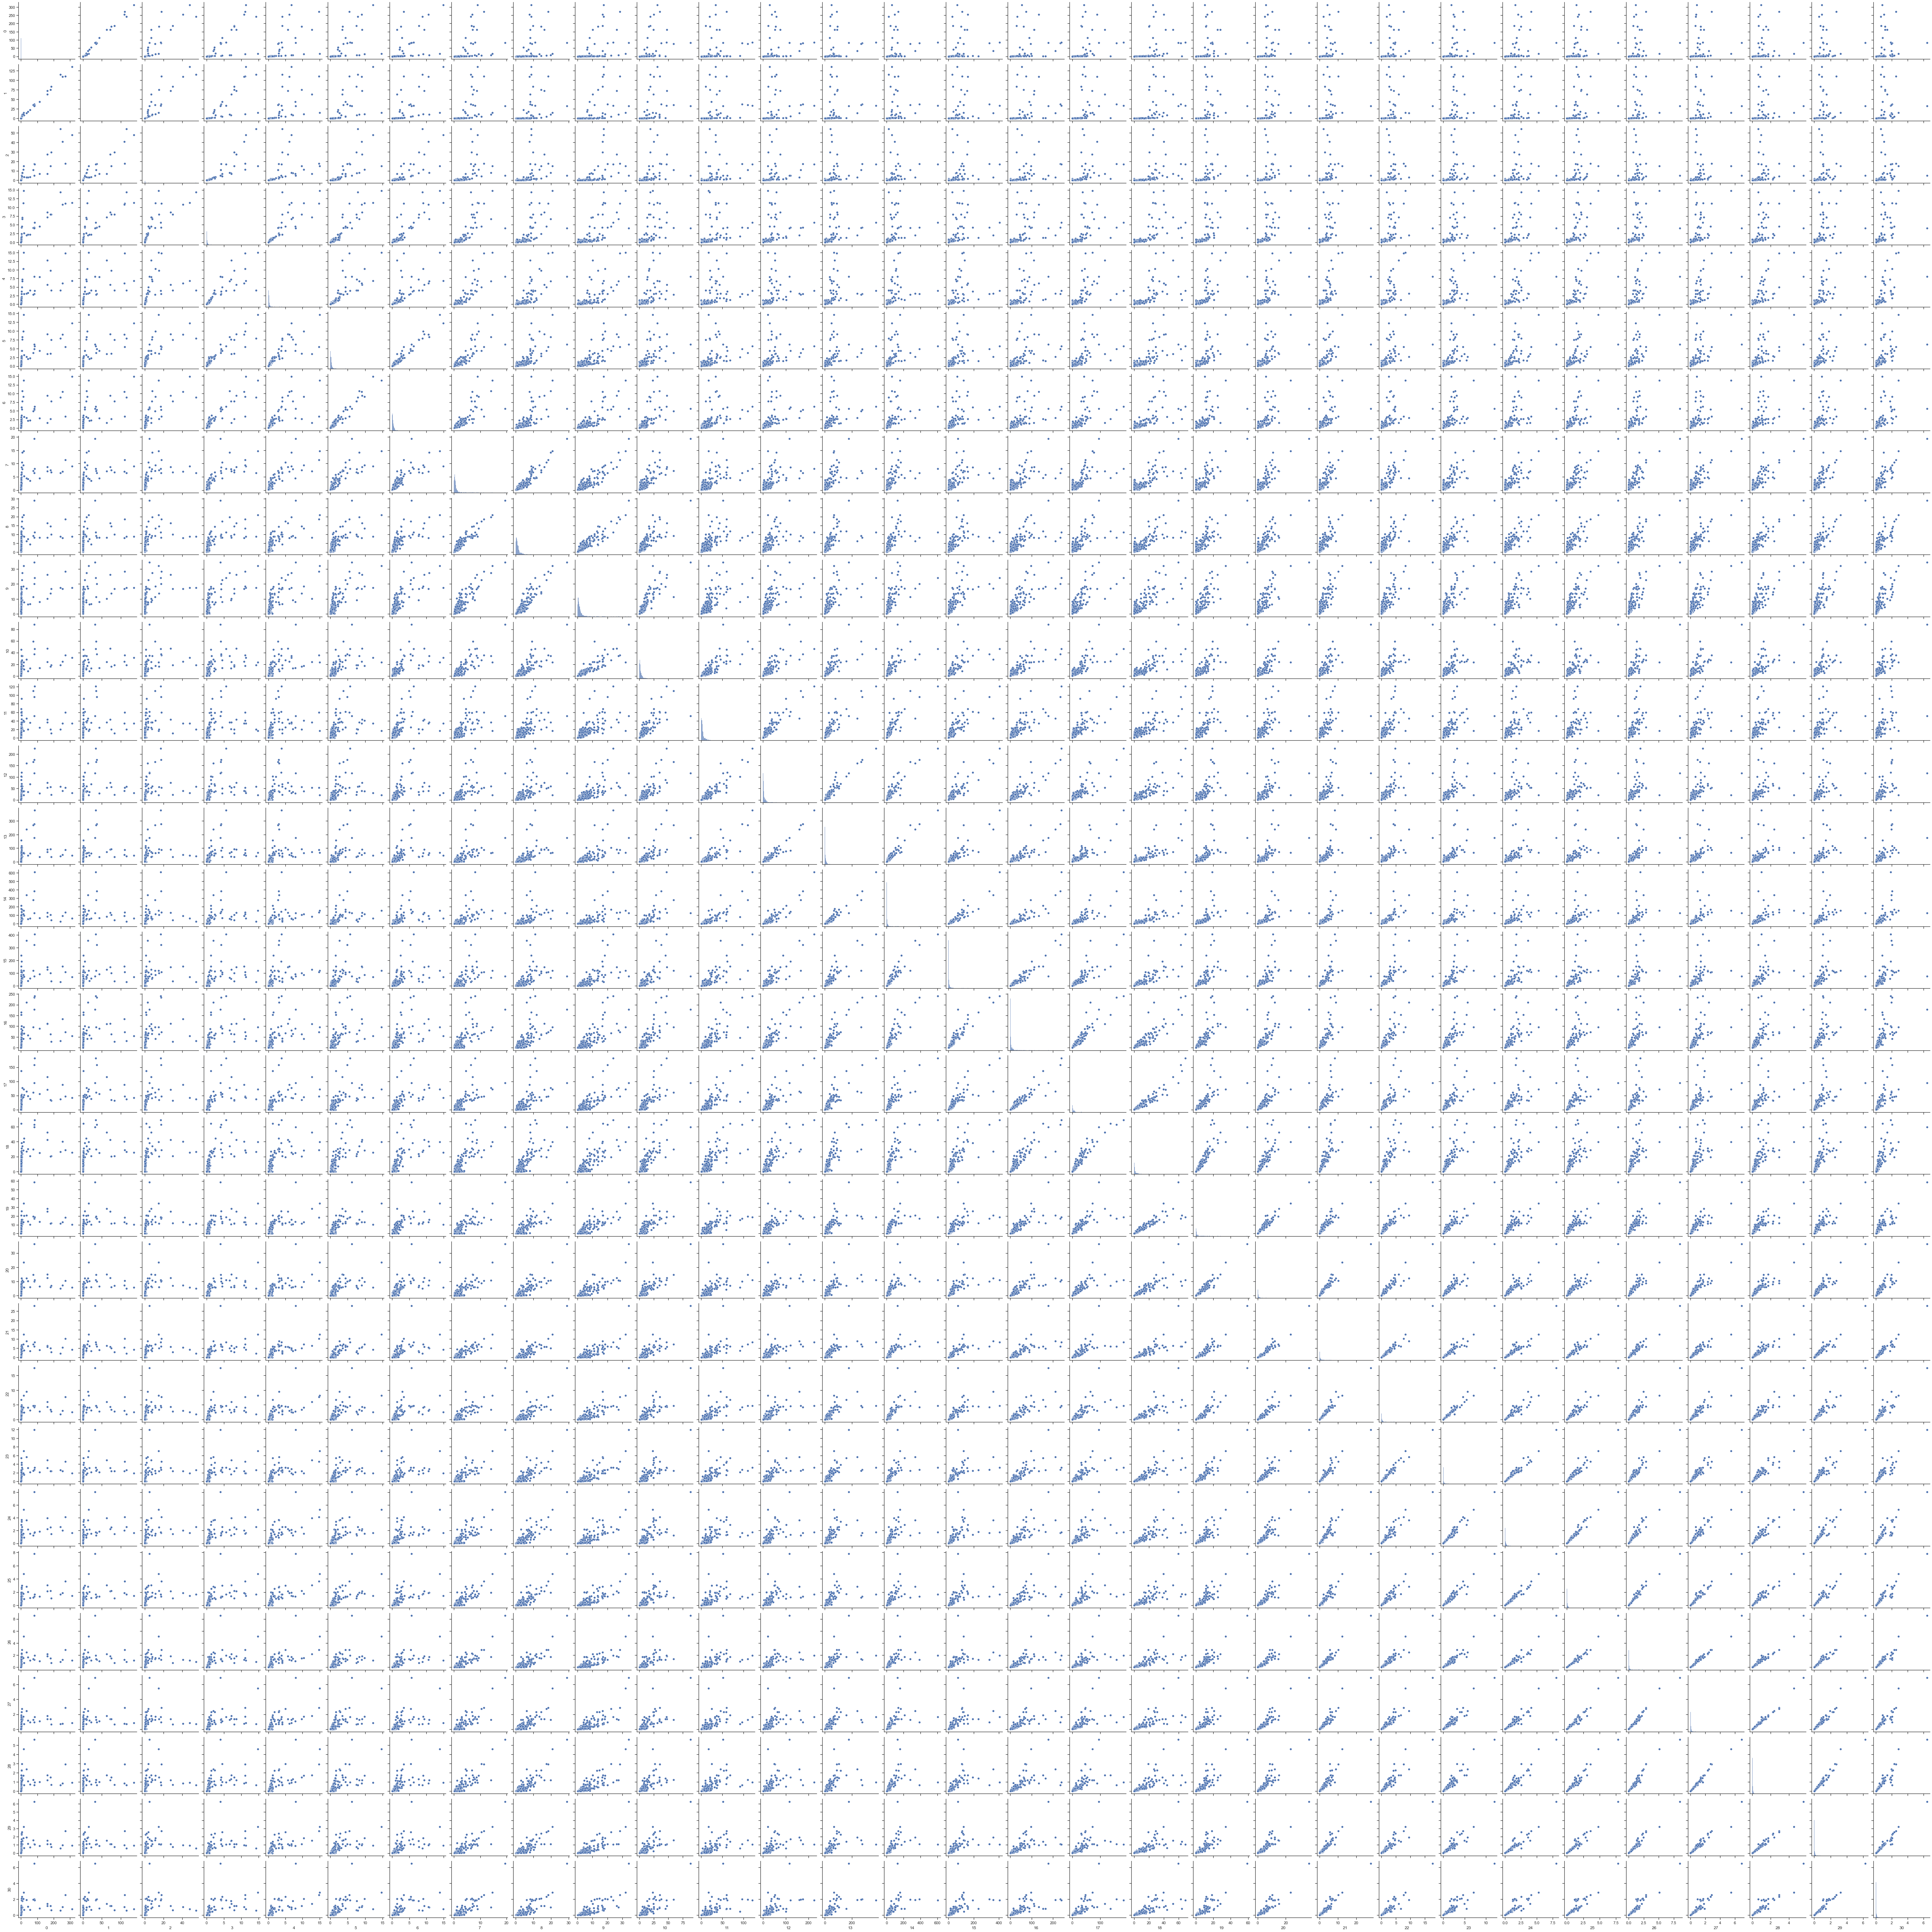

In [20]:
# inclusion
drawSpectraCorrelations(inclusion_features.values, sample_size=1000)

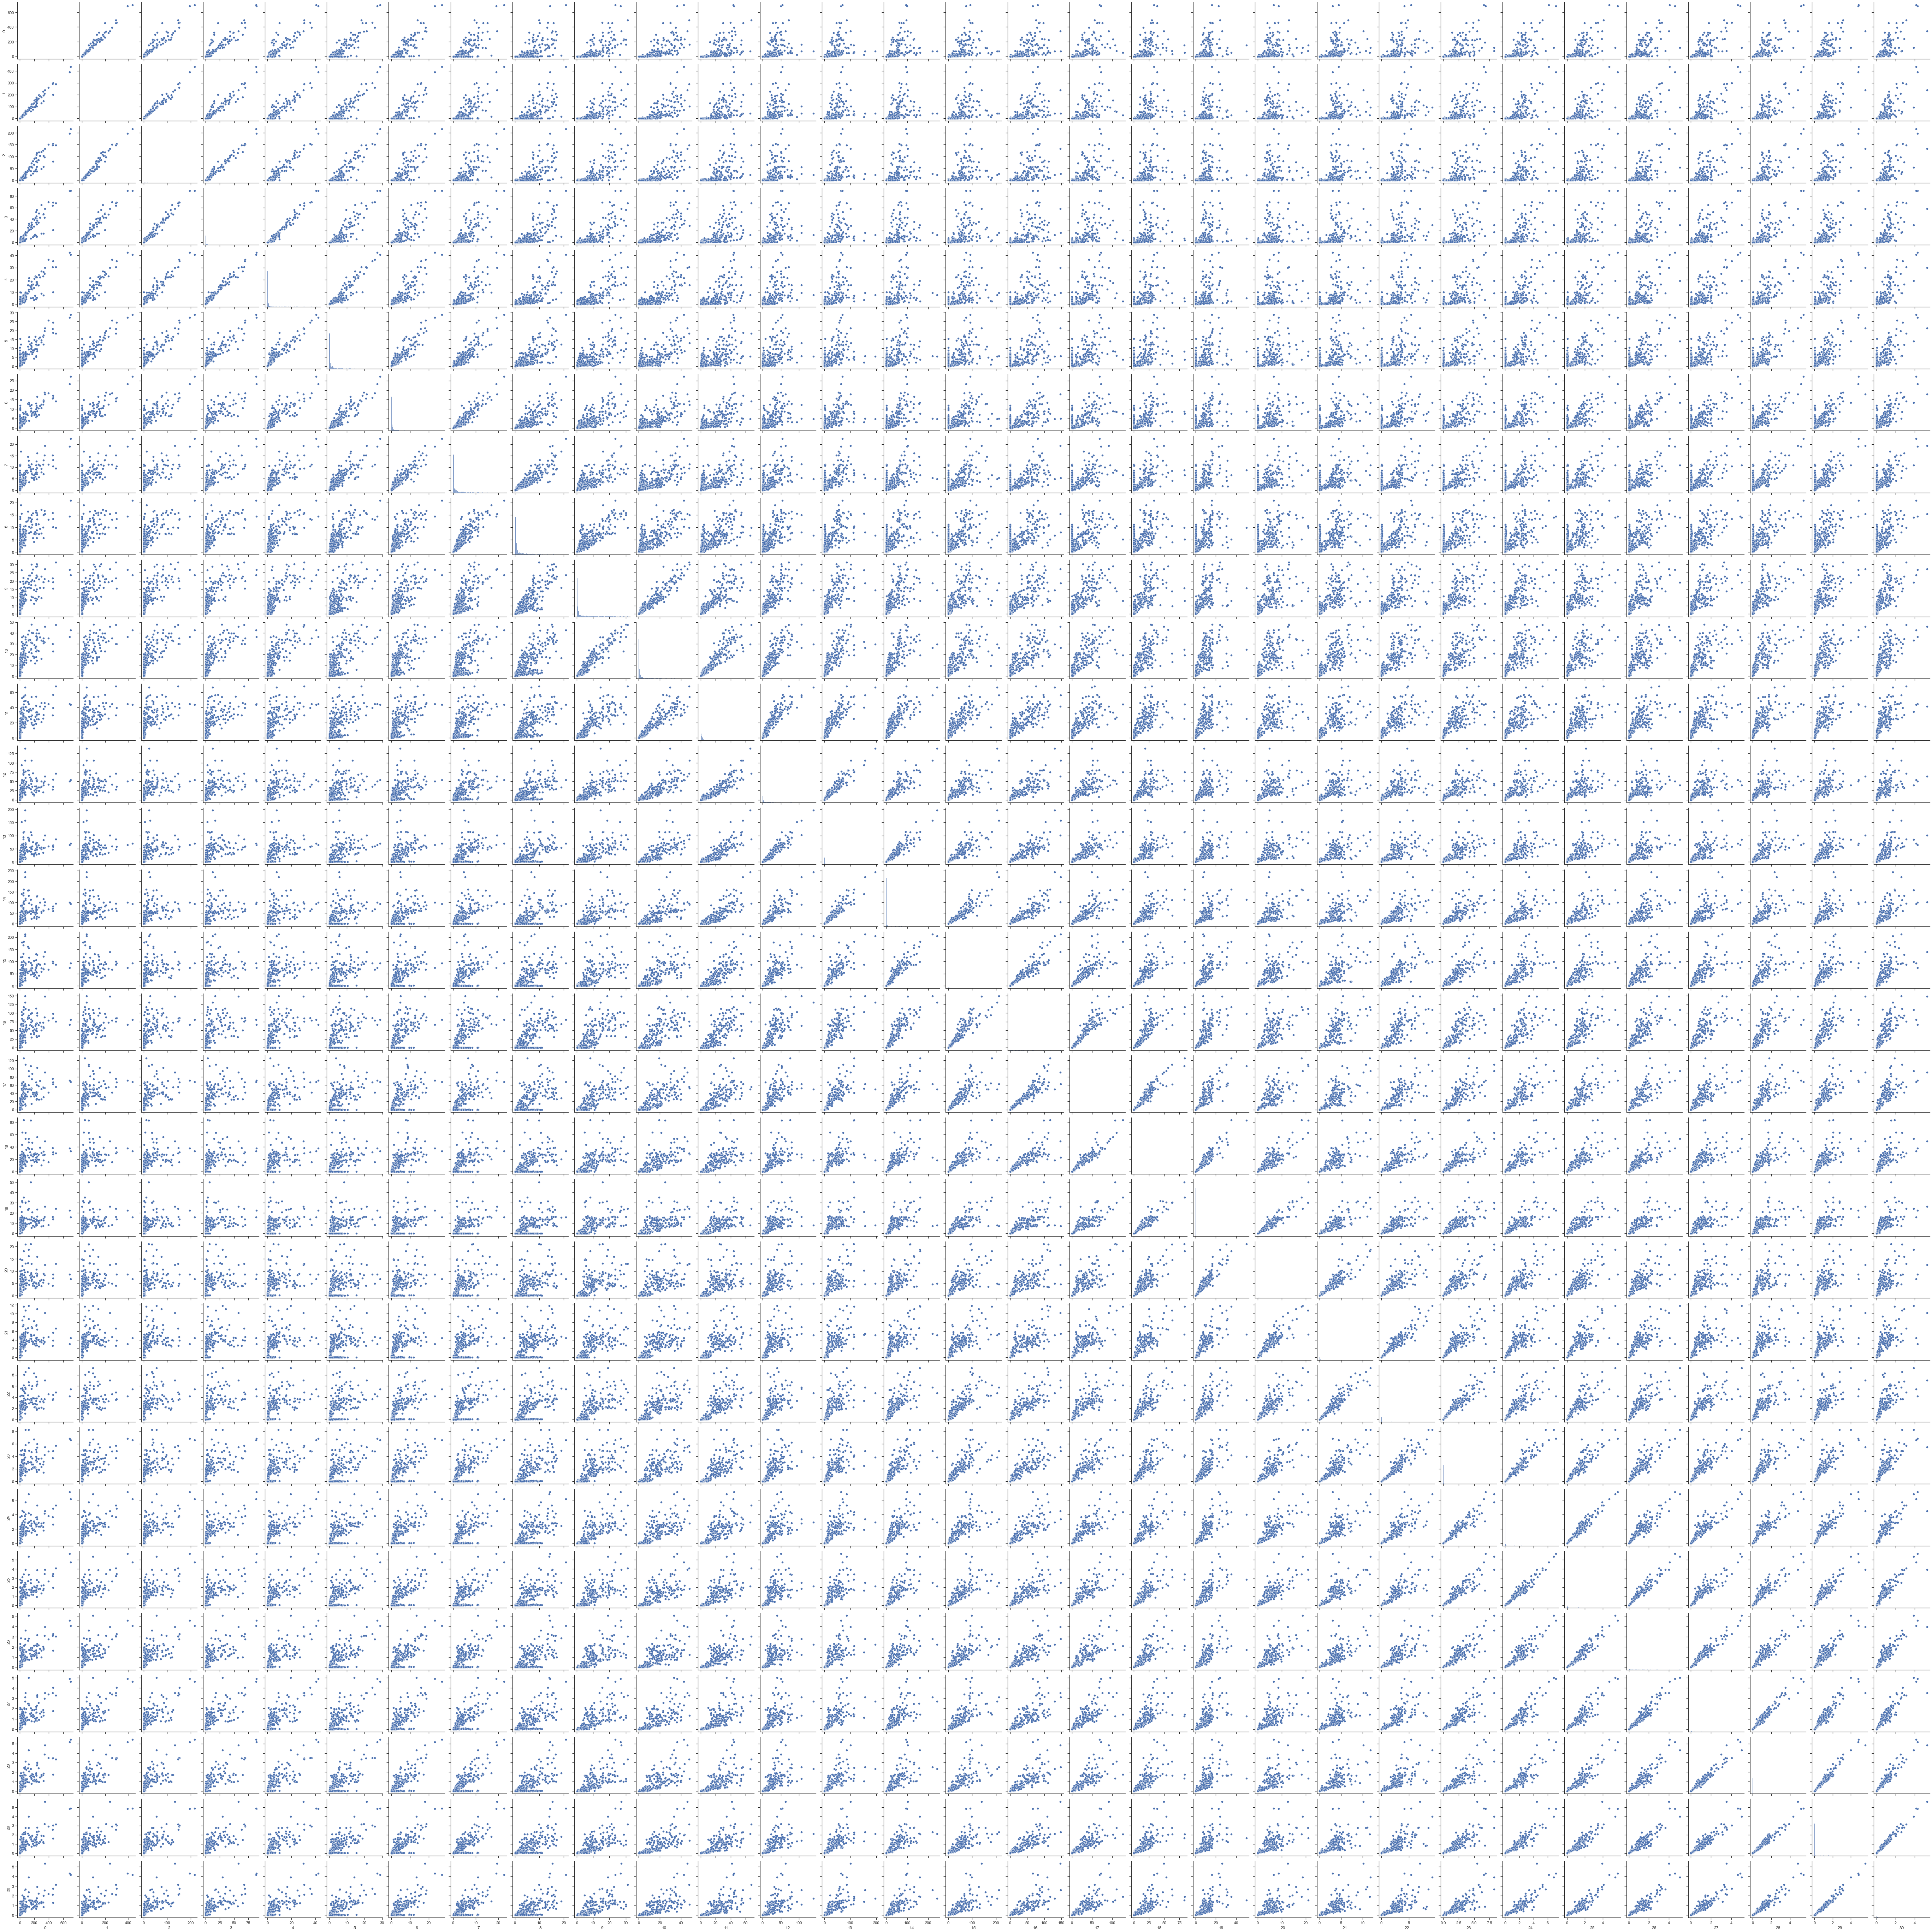

In [21]:
# non-inclusion
drawSpectraCorrelations(non_inclusion_features.values, sample_size=1000)